In [46]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
from sklearn.metrics import auc, roc_curve, classification_report
from scipy import stats

#import h2o
#from h2o.frame import H2OFrame
#from h2o.estimators.random_forest import H2ORandomForestEstimator
#from h2o.grid.grid_search import H2OGridSearch

%matplotlib inline
sns.set(style="white",context="talk")

# 1. Data Preview

In [34]:
test = pd.read_csv("test_table.csv", sep = ",")
user =  pd.read_csv("user_table.csv", sep = ",")

# since the test dataset contains more users, here I specify the left join
data = pd.merge(left=test, right=user, how='left', on='user_id')

In [35]:
# Let us first develop a preview of the merged 
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


In [36]:
# Exploring the data types, number of unique values and missing values of the A/B Testing dataset

print(f"The merged user test dataset consists of {data.shape[0]} rows and {data.shape[1]} columns, with 271,444 missing values in ads_channel\
(doesn't come through ads), and 454 missing values in user characteristics information \n")
pd.DataFrame({"data_types":data.dtypes, 
          "value_counts": data.nunique(),
          "null_counts": data.isnull().sum()}).set_index(data.dtypes.index)

The merged user test dataset consists of 453321 rows and 12 columns, with 271,444 missing values in ads_channel(doesn't come through ads), and 454 missing values in user characteristics information 



,data_types,value_counts,null_counts
user_id,int64,453321,0
date,object,5,0
source,object,3,0
device,object,2,0
browser_language,object,3,0
ads_channel,object,5,271444
browser,object,7,0
conversion,int64,2,0
test,int64,2,0
sex,object,2,454


In [37]:
# Next, let's take a look at the descriptive statistics
print("For numeric variables: \n",data.describe(),"\n")
print("For categorical variables: \n", data.describe(include = "object"))

For numeric variables: 
               user_id     conversion           test            age
count   453321.000000  453321.000000  453321.000000  452867.000000
mean    499937.514728       0.049579       0.476446      27.130740
std     288665.193436       0.217073       0.499445       6.776678
min          1.000000       0.000000       0.000000      18.000000
25%     249816.000000       0.000000       0.000000      22.000000
50%     500019.000000       0.000000       0.000000      26.000000
75%     749522.000000       0.000000       1.000000      31.000000
max    1000000.000000       1.000000       1.000000      70.000000 

For categorical variables: 
               date  source  device browser_language ads_channel      browser  \
count       453321  453321  453321           453321      181877       453321   
unique           5       3       2                3           5            7   
top     2015-12-04     Ads     Web               ES    Facebook  Android_App   
freq        141163  1

# 2. Data Cleaning

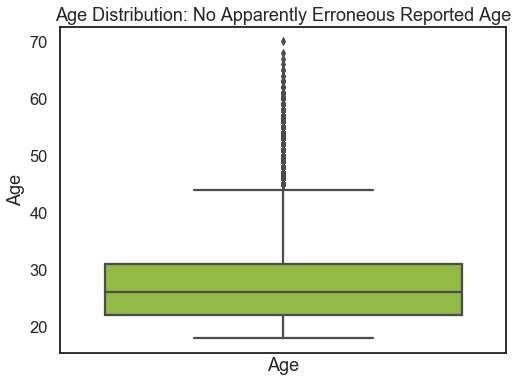

In [38]:
# Create the boxplots
f = plt.figure(figsize = (8,6))
sns.boxplot(data = data.age, color = "yellowgreen")

plt.title("Age Distribution: No Apparently Erroneous Reported Age")
plt.ylabel("Age")
plt.xlabel("Age")
plt.xticks([])

plt.show()

In [39]:
def get_outliers_count(df,col_name):

    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3 - Q1
    outliers = (df[col_name] < (Q1 - 1.5 * IQR)) | (df[col_name] > (Q3 + 1.5 * IQR))
    print(f"{col_name}: the maximum cutoff is {Q3+1.5*IQR}, the minimum cutoff is {Q1-1.5*IQR}, total number of outliers is: {outliers.sum()}")


get_outliers_count(data,"age")

age: the maximum cutoff is 44.5, the minimum cutoff is 8.5, total number of outliers is: 7493


In [40]:
# Replace null values in the ads_channel column
data["ads_channel"] = data["ads_channel"].fillna("non_ads_channel")

# Replace null values in all unmatched user columns as unknown
data[["sex","age","country"]] = data[["sex","age","country"]].fillna("unknown")

In [41]:
# Since the a/b test is a 5-day timeframe experiment, here I include a dayofweek column
wkday_dict = {1:"Mon",2:"Tue",3:"Wed",4:"Thu",5:"Fri",6:"Sat",7:"Sun"}
data['weekday'] = list(map(lambda x: wkday_dict[x], 
                           pd.Series(map(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'),data["date"])).dt.weekday+1))

# 3. A/B Testing

## 3-1. Experiment Overview

In [42]:
exp_group = data[data.test == 1]
ctr_group = data[data.test == 0]
exp_mean_conv = exp_group.groupby("date")["conversion"].mean().sort_values()
ctr_mean_conv = ctr_group.groupby("date")["conversion"].mean().sort_values()

# Define some basic variables
SIZE_EXP = len(exp_group)
SIZE_CTR = len(ctr_group)
date_axis = ['2015-11-30', '2015-12-01', '2015-12-02', '2015-12-03', '2015-12-04']

print(f"The size of the treatment group is {SIZE_EXP}, the size of the control group is {SIZE_CTR}")
print(f"The A/B Test lasts for 5 days: {date_axis}")

The size of the treatment group is 215983, the size of the control group is 237338
The A/B Test lasts for 5 days: ['2015-11-30', '2015-12-01', '2015-12-02', '2015-12-03', '2015-12-04']


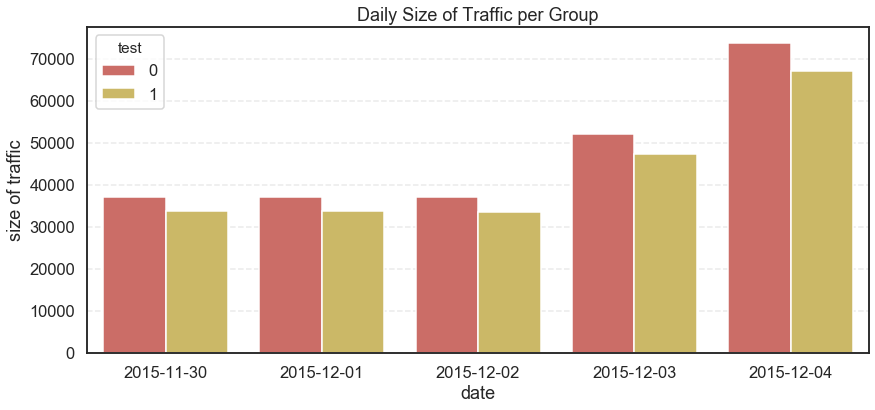

In [43]:
f = plt.figure(figsize=(14,6))
sns.barplot(x = "date", y = "user_id",hue = "test", data = data.groupby(["date","test"]).user_id.count().reset_index(),
            palette=sns.color_palette("hls", 8),)
plt.ylabel("size of traffic")
plt.title("Daily Size of Traffic per Group")
plt.grid(axis = "y",linestyle="--", alpha=0.4)

plt.show()

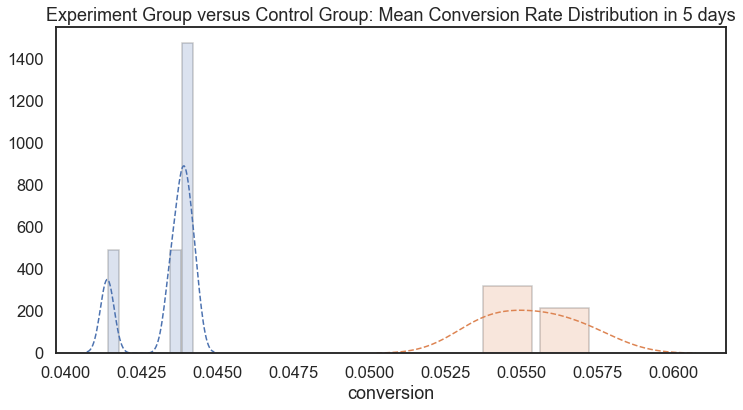

In [44]:
# Visualization of different sources
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2, 'rwidth':0.85}

fig = plt.figure(figsize=(12, 6))
sns.distplot(exp_mean_conv, label = "experiment group", hist = True, kde = True, hist_kws=hist_kws, kde_kws = {'linestyle':'--','linewidth':'1.5'})
sns.distplot(ctr_mean_conv, label = "control group", hist = True, kde = True, hist_kws=hist_kws, kde_kws = {'linestyle':'--','linewidth':'1.5'})
plt.title("Experiment Group versus Control Group: Mean Conversion Rate Distribution in 5 days")

plt.show()

## 3-2. Paired t-test

In [47]:
# 配对样本t检验是 “ttest_rel()”，无需检验方差是否一致


t, p = stats.ttest_ind(exp_mean_conv, ctr_mean_conv)

print(f"According to pairwise t-test, the t-stat is: {round(t,4)}, the p-value is: {p}\nTherefore, we reject the null hypothesis\
that the mean conversion rate is the same for the two groups.\n\n\
However, since the t-statistics is NEGATIVE, the treatment group actually underperforms the control group")


According to pairwise t-test, the t-stat is: -28.453, the p-value is: 9.07973820794381e-06
Therefore, we reject the null hypothesisthat the mean conversion rate is the same for the two groups.

However, since the t-statistics is NEGATIVE, the treatment group actually underperforms the control group


## 3-3. Sanity Check (Optional)
The unit of diversion needs to be random

In [48]:
def get_pct(df1, df2, nom_col, denom_col, pct_col):
    '''
    This helper function merges two dataframe on datetime,
    the output dataframe has a new percentage column (nom_col/denom_col)
    '''
    
    df = pd.merge(left = df1, right = df2, how = "left", on = "date")
    df[pct_col] = round(df[nom_col]/df[denom_col],4)
    return df

# Prepare for the denominator dataframe (the total traffic for each day)
traffic_by_day = data.groupby(by= ["date"])["user_id"].count().reset_index()
traffic_by_day.columns = ["date","total_users"]
traffic_by_day

,date,total_users
0,2015-11-30,71025
1,2015-12-01,70991
2,2015-12-02,70649
3,2015-12-03,99493
4,2015-12-04,141163


### Does the total number of users in the train set similar to that in the trest set?

In [49]:
traffic_by_group_day = data.groupby(by= ["date","weekday","test"])["user_id"].count().reset_index()
traffic_by_group_day.columns = ["date","weekday","test","cnt_users"]
traffic_by_group_day = get_pct(traffic_by_group_day, traffic_by_day, "cnt_users", "total_users", "pct_users")
traffic_by_group_day

,date,weekday,test,cnt_users,total_users,pct_users
0,2015-11-30,Mon,0,37142,71025,0.5229
1,2015-11-30,Mon,1,33883,71025,0.4771
2,2015-12-01,Tue,0,37116,70991,0.5228
3,2015-12-01,Tue,1,33875,70991,0.4772
4,2015-12-02,Wed,0,37100,70649,0.5251
5,2015-12-02,Wed,1,33549,70649,0.4749
6,2015-12-03,Thu,0,52073,99493,0.5234
7,2015-12-03,Thu,1,47420,99493,0.4766
8,2015-12-04,Fri,0,73907,141163,0.5236
9,2015-12-04,Fri,1,67256,141163,0.4764


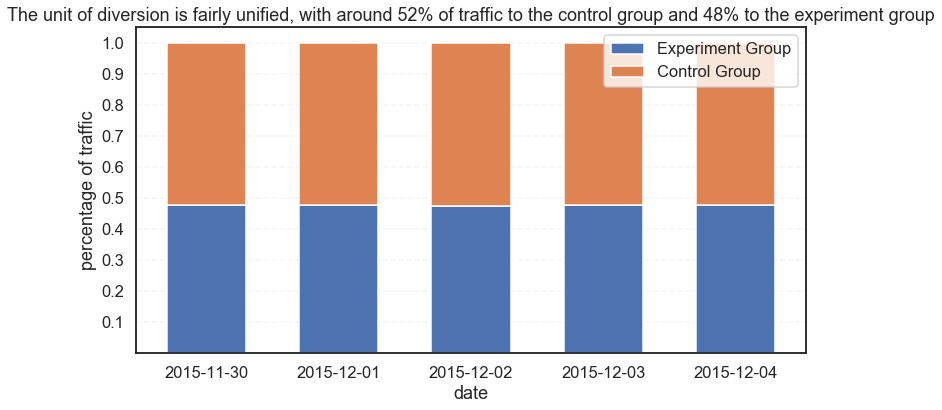

In [50]:
f = plt.figure(figsize = (12,6))
plt.bar(x = date_axis,
        height = traffic_by_group_day[traffic_by_group_day.test == 1].pct_users.values,
       width = 0.6)
plt.bar(x = date_axis,
        height = traffic_by_group_day[traffic_by_group_day.test == 0].pct_users.values,
       bottom = traffic_by_group_day[traffic_by_group_day.test == 1].pct_users.values,
       width = 0.6)
plt.title("The unit of diversion is fairly unified, with around 52% of traffic to the control group and 48% to the experiment group")
plt.legend(["Experiment Group","Control Group"])
plt.grid(axis = "y",linestyle="--", alpha=0.2)
plt.yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.ylabel("percentage of traffic")
plt.xlabel("date")

plt.show()

# 4. Analysis on Result

## 4-1. Conversion Rate by User Segment

#### By Country

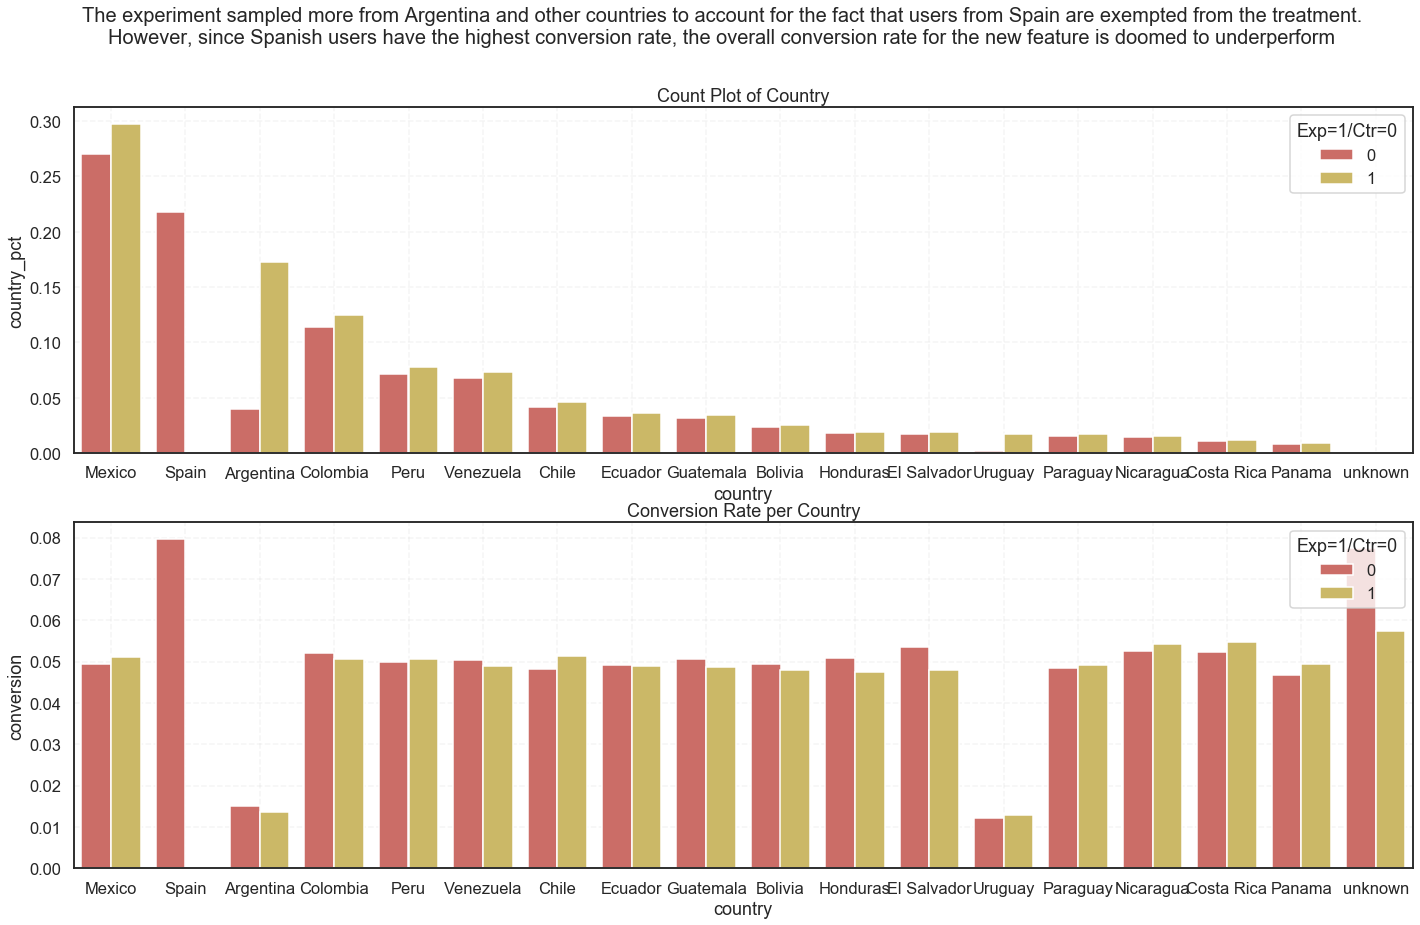

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(24, 14))

traffic_by_country = data.groupby(by= ["country","test"]).agg(
    {"user_id":"count","conversion":"mean"}).reset_index().sort_values("user_id",ascending = False)
traffic_by_country.columns = ["country","test","cnt_country","conversion"]
traffic_by_country["country_pct"] = 0
traffic_by_country.loc[traffic_by_country.test == 1,"country_pct"] = traffic_by_country[traffic_by_country.test == 1]["cnt_country"]/SIZE_EXP
traffic_by_country.loc[traffic_by_country.test == 0,"country_pct"] = traffic_by_country[traffic_by_country.test == 0]["cnt_country"]/SIZE_CTR

sns.barplot(x='country', y = "country_pct", hue = "test", data=traffic_by_country,
            ax=axes[0], palette=sns.color_palette("hls", 8))
axes[0].set_title('Count Plot of Country', fontsize=18)
axes[0].grid(linestyle="--", alpha=0.2)
axes[0].legend(title = "Exp=1/Ctr=0",loc = 1)

sns.barplot(x='country', y='conversion',hue = "test", data=traffic_by_country, 
            ci=0, ax=axes[1], palette=sns.color_palette("hls", 8))
axes[1].set_title('Conversion Rate per Country', fontsize=18)
axes[1].grid(linestyle="--", alpha=0.2)
axes[1].legend(title = "Exp=1/Ctr=0",loc = 1)

fig.suptitle("The experiment sampled more from Argentina and other countries to account for \
the fact that users from Spain are exempted from the treatment.\n\
However, since Spanish users have the highest conversion rate, the overall conversion rate for the new feature is doomed to underperform",fontsize = 20)
plt.show()

In [54]:
conv_diff_by_country = pd.concat([pd.DataFrame(exp_group.groupby("country").conversion.mean()), 
                                 pd.DataFrame(ctr_group.groupby("country").conversion.mean())],axis = 1).drop("Spain",axis = 0)
conv_diff_by_country.columns = ["conv_exp","conv_ctr"]
conv_diff_by_country["conv_diff"] = conv_diff_by_country["conv_exp"] - conv_diff_by_country["conv_ctr"]

success_countries = list(conv_diff_by_country[conv_diff_by_country.conv_diff>0].index)
unsuccess_countries = list(conv_diff_by_country[conv_diff_by_country.conv_diff<0].index)

In [55]:
print(f"Excluding Spain:\nThe 8 countries that have positive influence on conversion rate includes: {success_countries}\n")
print(f"Excluding Spain:\nThe 9 countries that fail to impose positive influence on conversion rate includes: {unsuccess_countries}")

Excluding Spain:
The 8 countries that have positive influence on conversion rate includes: ['Chile', 'Costa Rica', 'Mexico', 'Nicaragua', 'Panama', 'Paraguay', 'Peru', 'Uruguay']

Excluding Spain:
The 9 countries that fail to impose positive influence on conversion rate includes: ['Argentina', 'Bolivia', 'Colombia', 'Ecuador', 'El Salvador', 'Guatemala', 'Honduras', 'Venezuela', 'unknown']


##### Countries-overall t-test: Countries where conversion rate is higher (The localized translation is actually effective)

In [56]:
t, p = stats.ttest_rel(exp_group[exp_group.country.isin(success_countries)].groupby("date").conversion.mean(), 
                       ctr_group[ctr_group.country.isin(success_countries)].groupby("date").conversion.mean())

print(f"According to pairwise t-test, the t-stat is: {round(t,4)}, the p-value is: {round(p,4)}\nTherefore, we fail to \
reject the null hypothesis that the mean conversion rate is the same for the two groups")

According to pairwise t-test, the t-stat is: 0.2347, the p-value is: 0.8259
Therefore, we fail to reject the null hypothesis that the mean conversion rate is the same for the two groups


##### Countries-overall t-test: Countries where conversion rate is not higher (The localized translation is not effective)

In [57]:
t, p = stats.ttest_rel(exp_group[exp_group.country.isin(unsuccess_countries)].groupby("date").conversion.mean(), 
                       ctr_group[ctr_group.country.isin(unsuccess_countries)].groupby("date").conversion.mean())

print(f"According to pairwise t-test, the t-stat is: {round(t,4)}, the p-value is: {round(p,4)}\nTherefore, we \
reject the null hypothesis that the mean conversion rate is the same for the two groups")

According to pairwise t-test, the t-stat is: -11.7408, the p-value is: 0.0003
Therefore, we reject the null hypothesis that the mean conversion rate is the same for the two groups


##### Country-specific t-test: Countries where conversion rate is higher (The localized translation is actually effective)

In [58]:
for area in success_countries:
    t, p = stats.ttest_rel(exp_group[exp_group.country == area].groupby("date").conversion.mean(), 
                           ctr_group[ctr_group.country == area].groupby("date").conversion.mean())

    print(f"For {area} users, according to pairwise t-test, the t-stat is: {round(t,4)}, the p-value is: {round(p,4)}\nTherefore, we fail to \
reject the null hypothesis that the mean conversion rate is the same for the two groups.\n")

For Chile users, according to pairwise t-test, the t-stat is: 0.6967, the p-value is: 0.5244
Therefore, we fail to reject the null hypothesis that the mean conversion rate is the same for the two groups.

For Costa Rica users, according to pairwise t-test, the t-stat is: 0.1522, the p-value is: 0.8864
Therefore, we fail to reject the null hypothesis that the mean conversion rate is the same for the two groups.

For Mexico users, according to pairwise t-test, the t-stat is: 2.2041, the p-value is: 0.0922
Therefore, we fail to reject the null hypothesis that the mean conversion rate is the same for the two groups.

For Nicaragua users, according to pairwise t-test, the t-stat is: 0.5295, the p-value is: 0.6245
Therefore, we fail to reject the null hypothesis that the mean conversion rate is the same for the two groups.

For Panama users, according to pairwise t-test, the t-stat is: 0.1387, the p-value is: 0.8964
Therefore, we fail to reject the null hypothesis that the mean conversion ra

##### Country-specific t-test: Countries where conversion rate is not higher (The localized translation is not effective)

In [59]:
for area in unsuccess_countries:
    t, p = stats.ttest_rel(exp_group[exp_group.country == area].groupby("date").conversion.mean(), 
                           ctr_group[ctr_group.country == area].groupby("date").conversion.mean())

    print(f"For {area} users, according to pairwise t-test, the t-stat is: {round(t,4)}, the p-value is: {round(p,4)}\nTherefore, we fail to \
reject the null hypothesis that the mean conversion rate is the same for the two groups.\n")

For Argentina users, according to pairwise t-test, the t-stat is: -1.0968, the p-value is: 0.3343
Therefore, we fail to reject the null hypothesis that the mean conversion rate is the same for the two groups.

For Bolivia users, according to pairwise t-test, the t-stat is: -0.9449, the p-value is: 0.3982
Therefore, we fail to reject the null hypothesis that the mean conversion rate is the same for the two groups.

For Colombia users, according to pairwise t-test, the t-stat is: -1.671, the p-value is: 0.17
Therefore, we fail to reject the null hypothesis that the mean conversion rate is the same for the two groups.

For Ecuador users, according to pairwise t-test, the t-stat is: -0.0974, the p-value is: 0.9271
Therefore, we fail to reject the null hypothesis that the mean conversion rate is the same for the two groups.

For El Salvador users, according to pairwise t-test, the t-stat is: -1.1334, the p-value is: 0.3204
Therefore, we fail to reject the null hypothesis that the mean conve

### If we exclude all session records in Spain from the control group, we get a more trustworthy t-test design
 since the t-statistics is NEGATIVE, the treatment group actually underperforms the control group

In [60]:
t, p = stats.ttest_rel(exp_mean_conv, ctr_group[ctr_group.country != "Spain"].groupby("date").conversion.mean())

print(f"According to pairwise t-test, the t-stat is: {round(t,4)}, the p-value is: {p}\nTherefore, we reject the null hypothesis\
that the mean conversion rate is the same for the two groups.\n\n\
However, since the t-statistics is NEGATIVE, the treatment group actually underperforms the control group")


According to pairwise t-test, the t-stat is: -3.8937, the p-value is: 0.01763539097066269
Therefore, we reject the null hypothesisthat the mean conversion rate is the same for the two groups.

However, since the t-statistics is NEGATIVE, the treatment group actually underperforms the control group


#### By Age

In [61]:
# Transform age into bins
def age_transform(age):
    if isinstance(age,str):
        return "unknown"
    else:
        if 10<age<=20:
            return "10~20"
        elif 20<age<=30:
            return "20~30"
        elif 30<age<=40:
            return "30~40"
        elif 40<age<=50:
            return "40~50"
        else:
            return ">50"
data["age_range"] = data.age.map(age_transform)

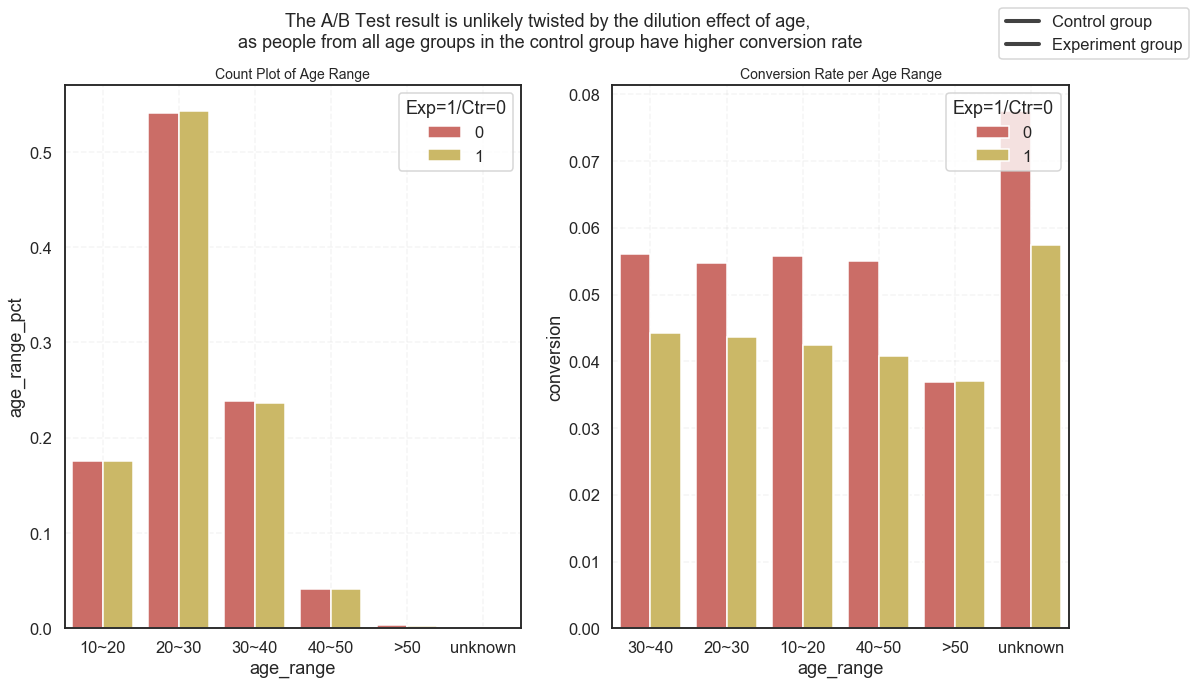

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))

traffic_by_age_range = data.groupby(by= ["age_range","test"])["user_id"].count().reset_index()
traffic_by_age_range.columns = ["age_range","test","cnt_age_range"]
traffic_by_age_range["age_range_pct"] = 0
traffic_by_age_range.loc[traffic_by_age_range.test == 1,"age_range_pct"] = traffic_by_age_range[traffic_by_age_range.test == 1]["cnt_age_range"]/SIZE_EXP
traffic_by_age_range.loc[traffic_by_age_range.test == 0,"age_range_pct"] = traffic_by_age_range[traffic_by_age_range.test == 0]["cnt_age_range"]/SIZE_CTR


sns.barplot(x='age_range', y = "age_range_pct", hue = "test", data=traffic_by_age_range,ax=axes[0], palette=sns.color_palette("hls", 8))
axes[0].set_title('Count Plot of Age Range', fontsize=14)
axes[0].grid(linestyle="--", alpha=0.2)
axes[0].legend(title = "Exp=1/Ctr=0",loc = 1)

sns.barplot(x='age_range', y='conversion',hue = "test", data=data, ci=0, ax=axes[1], palette=sns.color_palette("hls", 8))
axes[1].set_title('Conversion Rate per Age Range', fontsize=14)
axes[1].grid(linestyle="--", alpha=0.2)
axes[1].legend(title = "Exp=1/Ctr=0",loc = 1)


fig.legend(["Control group","Experiment group"],loc = 0)
#plt.xticks(np.arange(len(["10~20","20~30","30~40","40~50",">50","unknown"])), ["10~20","20~30","30~40","40~50",">50","unknown"])
fig.suptitle("The A/B Test result is unlikely twisted by the dilution effect of age, \nas people from all age groups in the control group have higher conversion rate",fontsize = 18)
plt.show()

#### By Source (Marketing Channels)

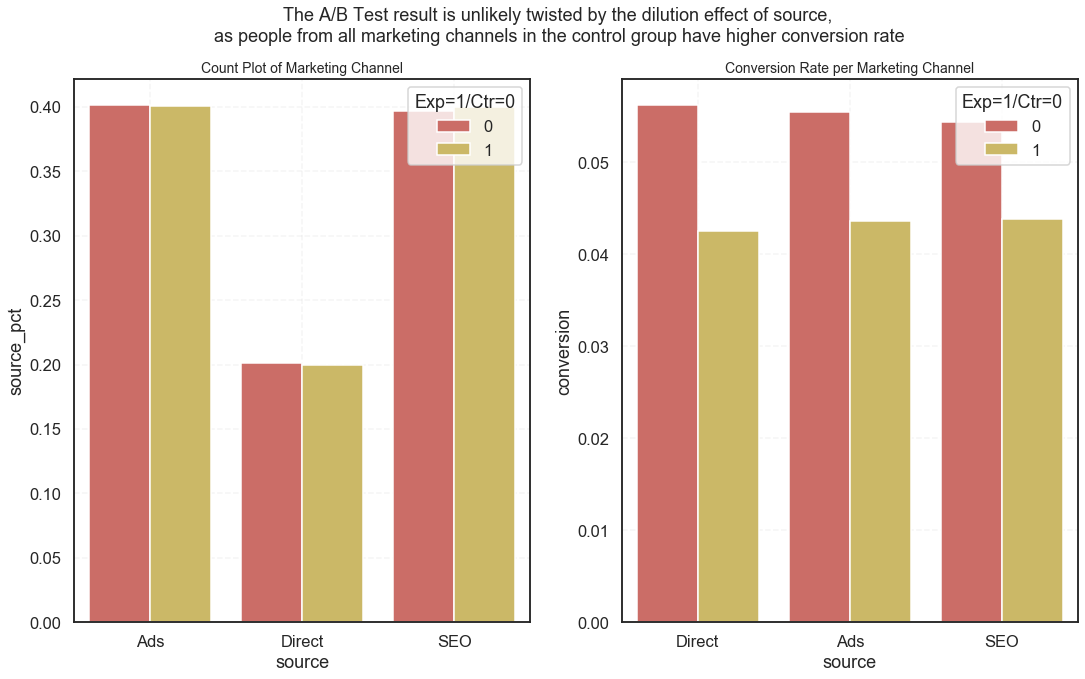

In [63]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))

traffic_by_source = data.groupby(by= ["source","test"])["user_id"].count().reset_index()
traffic_by_source.columns = ["source","test","cnt_source"]
traffic_by_source["source_pct"] = 0
traffic_by_source.loc[traffic_by_source.test == 1,"source_pct"] = traffic_by_source[traffic_by_source.test == 1]["cnt_source"]/SIZE_EXP
traffic_by_source.loc[traffic_by_source.test == 0,"source_pct"] = traffic_by_source[traffic_by_source.test == 0]["cnt_source"]/SIZE_CTR

sns.barplot(x='source',y = "source_pct", hue = "test", data=traffic_by_source, ax=axes[0], palette=sns.color_palette("hls", 8))
axes[0].set_title('Count Plot of Marketing Channel', fontsize=14)
axes[0].grid(linestyle="--", alpha=0.2)
axes[0].legend(title = "Exp=1/Ctr=0",loc = 1)

sns.barplot(x='source', y='conversion',hue = "test", data=data, ci=0, ax=axes[1], palette=sns.color_palette("hls", 8))
axes[1].set_title('Conversion Rate per Marketing Channel', fontsize=14)
axes[1].grid(linestyle="--", alpha=0.2)
axes[1].legend(title = "Exp=1/Ctr=0",loc = 1)


fig.suptitle("The A/B Test result is unlikely twisted by the dilution effect of source, \nas people from all marketing channels in the control group have higher conversion rate",fontsize = 18)
plt.show()

#### By Device

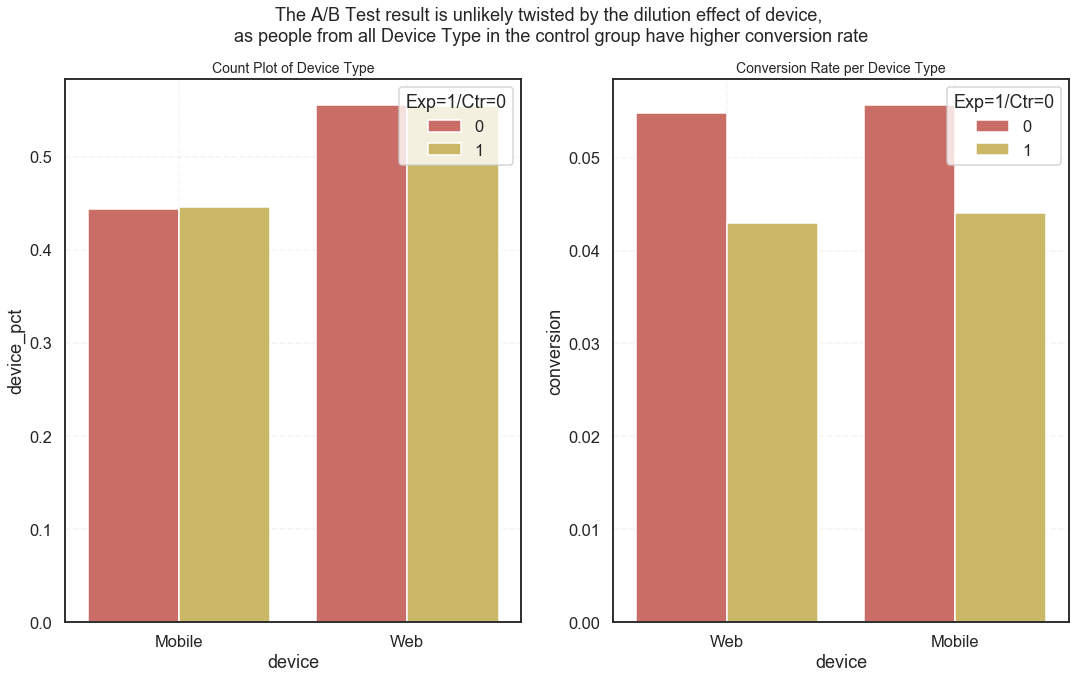

In [64]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))

traffic_by_device = data.groupby(by= ["device","test"])["user_id"].count().reset_index()
traffic_by_device.columns = ["device","test","cnt_device"]
traffic_by_device["device_pct"] = 0
traffic_by_device.loc[traffic_by_device.test == 1,"device_pct"] = traffic_by_device[traffic_by_device.test == 1]["cnt_device"]/SIZE_EXP
traffic_by_device.loc[traffic_by_device.test == 0,"device_pct"] = traffic_by_device[traffic_by_device.test == 0]["cnt_device"]/SIZE_CTR

sns.barplot(x='device',y = "device_pct",hue = "test", data=traffic_by_device,ax=axes[0], palette=sns.color_palette("hls", 8))
axes[0].set_title('Count Plot of Device Type', fontsize=14)
axes[0].grid(linestyle="--", alpha=0.2)
axes[0].legend(title = "Exp=1/Ctr=0",loc = 1)

sns.barplot(x='device', y='conversion',hue = "test", data=data, ci=0, ax=axes[1], palette=sns.color_palette("hls", 8))
axes[1].set_title('Conversion Rate per Device Type', fontsize=14)
axes[1].grid(linestyle="--", alpha=0.2)
axes[1].legend(title = "Exp=1/Ctr=0",loc = 1)


#fig.legend(["Control group","Experiment group"],loc = 0)
fig.suptitle("The A/B Test result is unlikely twisted by the dilution effect of device, \nas people from all Device Type in the control group have higher conversion rate",fontsize = 18)
plt.show()

#### By Browser Language

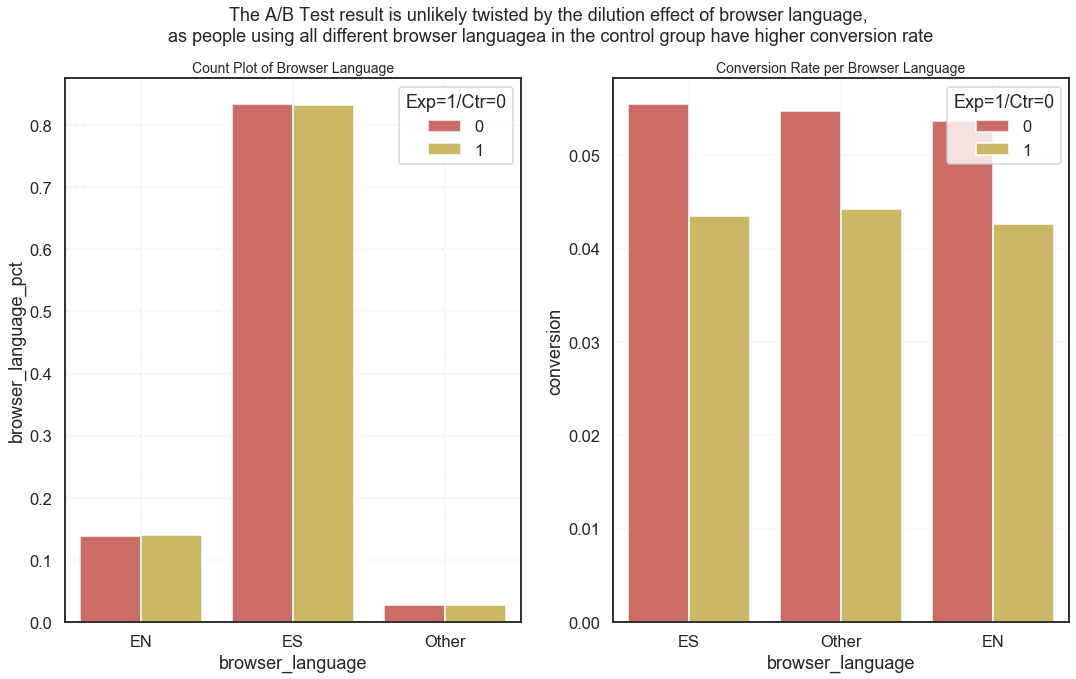

In [65]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))

traffic_by_browser_language = data.groupby(by= ["browser_language","test"])["user_id"].count().reset_index()
traffic_by_browser_language.columns = ["browser_language","test","cnt_browser_language"]
traffic_by_browser_language["browser_language_pct"] = 0
traffic_by_browser_language.loc[traffic_by_browser_language.test == 1,"browser_language_pct"] = traffic_by_browser_language[traffic_by_browser_language.test == 1]["cnt_browser_language"]/SIZE_EXP
traffic_by_browser_language.loc[traffic_by_browser_language.test == 0,"browser_language_pct"] = traffic_by_browser_language[traffic_by_browser_language.test == 0]["cnt_browser_language"]/SIZE_CTR

sns.barplot(x='browser_language',y = "browser_language_pct",hue = "test", data=traffic_by_browser_language,ax=axes[0], palette=sns.color_palette("hls", 8))
axes[0].set_title('Count Plot of Browser Language', fontsize=14)
axes[0].grid(linestyle="--", alpha=0.2)
axes[0].legend(title = "Exp=1/Ctr=0",loc = 1)

sns.barplot(x='browser_language', y='conversion',hue = "test", data=data, ci=0, ax=axes[1], palette=sns.color_palette("hls", 8))
axes[1].set_title('Conversion Rate per Browser Language', fontsize=14)
axes[1].grid(linestyle="--", alpha=0.2)
axes[1].legend(title = "Exp=1/Ctr=0",loc = 1)


#fig.legend(["Control group","Experiment group"],loc = 0)
fig.suptitle("The A/B Test result is unlikely twisted by the dilution effect of browser language, \nas people using all different browser languagea in the control group have higher conversion rate",fontsize = 18)
plt.show()

#### By Browser

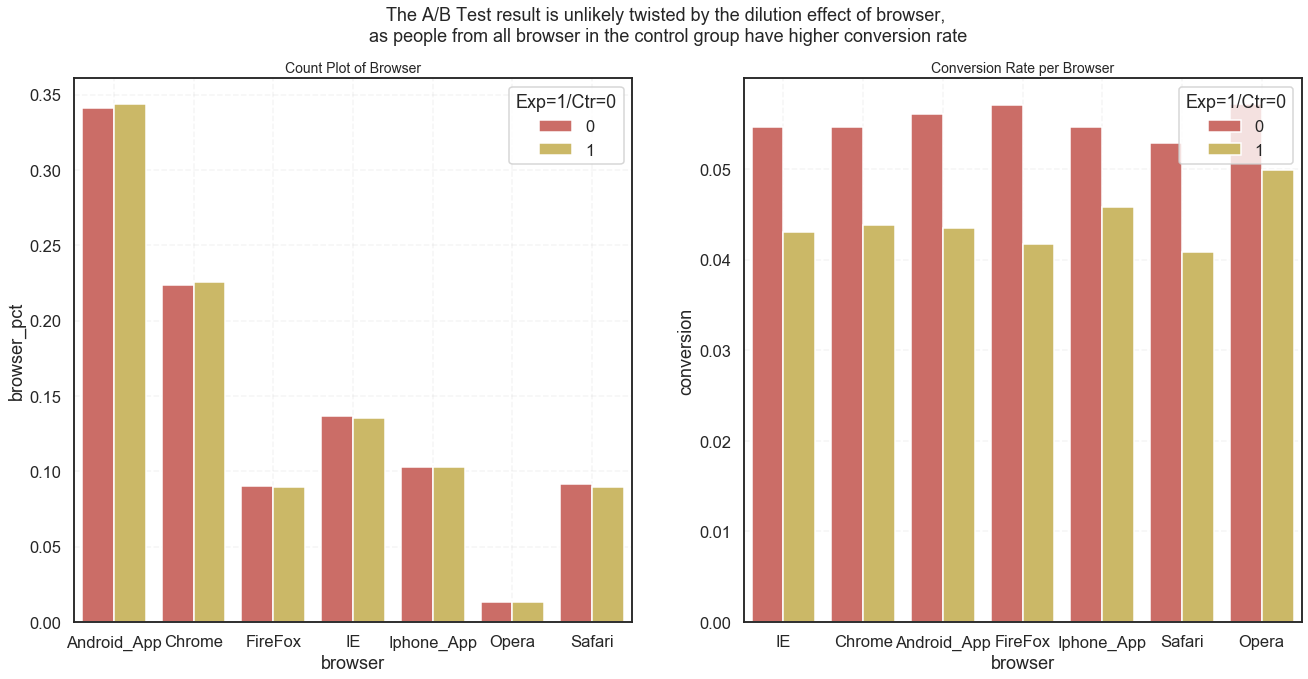

In [66]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))

traffic_by_browser = data.groupby(by= ["browser","test"])["user_id"].count().reset_index()
traffic_by_browser.columns = ["browser","test","cnt_browser"]
traffic_by_browser["browser_pct"] = 0
traffic_by_browser.loc[traffic_by_browser.test == 1,"browser_pct"] = traffic_by_browser[traffic_by_browser.test == 1]["cnt_browser"]/SIZE_EXP
traffic_by_browser.loc[traffic_by_browser.test == 0,"browser_pct"] = traffic_by_browser[traffic_by_browser.test == 0]["cnt_browser"]/SIZE_CTR

sns.barplot(x='browser',y = "browser_pct",hue = "test", data = traffic_by_browser,ax=axes[0], palette=sns.color_palette("hls", 8))
axes[0].set_title('Count Plot of Browser', fontsize=14)
axes[0].grid(linestyle="--", alpha=0.2)
axes[0].legend(title = "Exp=1/Ctr=0",loc = 1)

sns.barplot(x='browser', y='conversion',hue = "test", data=data, ci=0, ax=axes[1], palette=sns.color_palette("hls", 8))
axes[1].set_title('Conversion Rate per Browser', fontsize=14)
axes[1].grid(linestyle="--", alpha=0.2)
axes[1].legend(title = "Exp=1/Ctr=0",loc = 1)


#fig.legend(["Control group","Experiment group"],loc = 0)
fig.suptitle("The A/B Test result is unlikely twisted by the dilution effect of browser, \nas people from all browser in the control group have higher conversion rate",fontsize = 18)
plt.show()

#### By Ads Channel

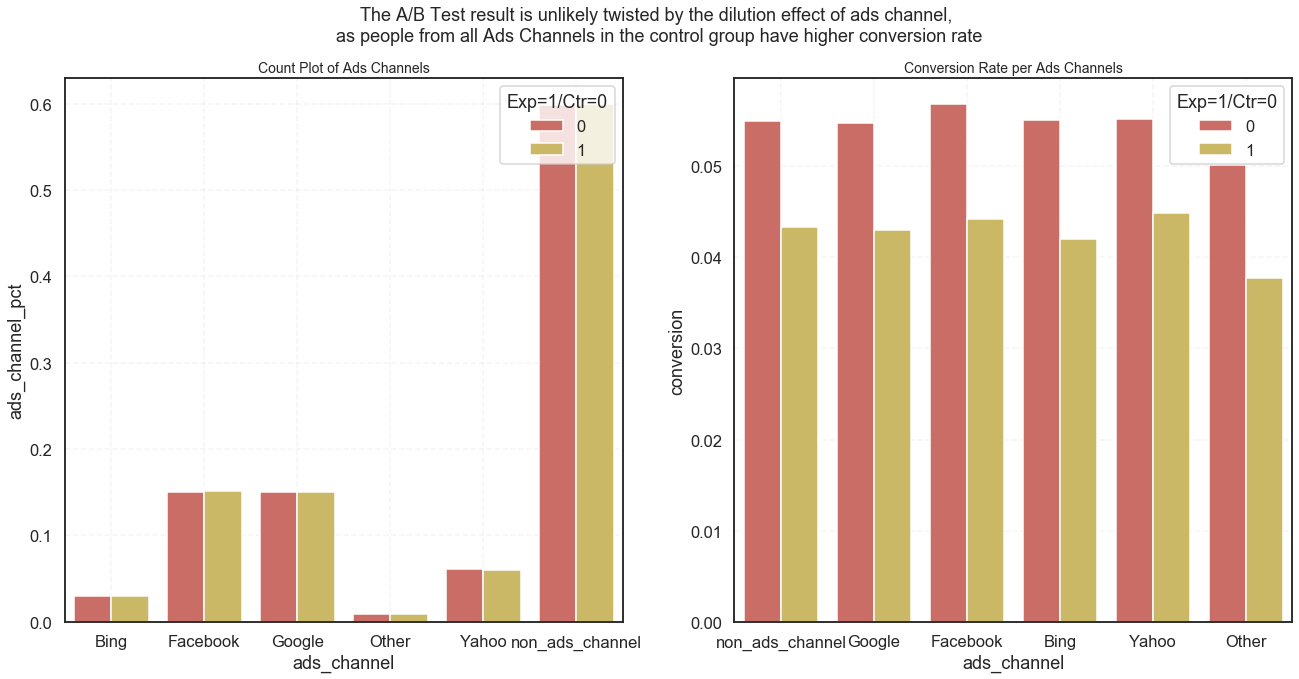

In [67]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))

traffic_by_ads_channel = data.groupby(by= ["ads_channel","test"])["user_id"].count().reset_index()
traffic_by_ads_channel.columns = ["ads_channel","test","cnt_ads_channel"]
traffic_by_ads_channel["ads_channel_pct"] = 0
traffic_by_ads_channel.loc[traffic_by_ads_channel.test == 1,"ads_channel_pct"] = traffic_by_ads_channel[traffic_by_ads_channel.test == 1]["cnt_ads_channel"]/SIZE_EXP
traffic_by_ads_channel.loc[traffic_by_ads_channel.test == 0,"ads_channel_pct"] = traffic_by_ads_channel[traffic_by_ads_channel.test == 0]["cnt_ads_channel"]/SIZE_CTR

sns.barplot(x='ads_channel',y = "ads_channel_pct",hue = "test", data=traffic_by_ads_channel,ax=axes[0], palette=sns.color_palette("hls", 8))
axes[0].set_title('Count Plot of Ads Channels', fontsize=14)
axes[0].grid(linestyle="--", alpha=0.2)
axes[0].legend(title = "Exp=1/Ctr=0",loc = 1)

sns.barplot(x='ads_channel', y='conversion',hue = "test", data=data, ci=0, ax=axes[1], palette=sns.color_palette("hls", 8))
axes[1].set_title('Conversion Rate per Ads Channels', fontsize=14)
axes[1].grid(linestyle="--", alpha=0.2)
axes[1].legend(title = "Exp=1/Ctr=0",loc = 1)


#fig.legend(["Control group","Experiment group"],loc = 0)
fig.suptitle("The A/B Test result is unlikely twisted by the dilution effect of ads channel, \nas people from all Ads Channels in the control group have higher conversion rate",fontsize = 18)
plt.show()

#### By Sex

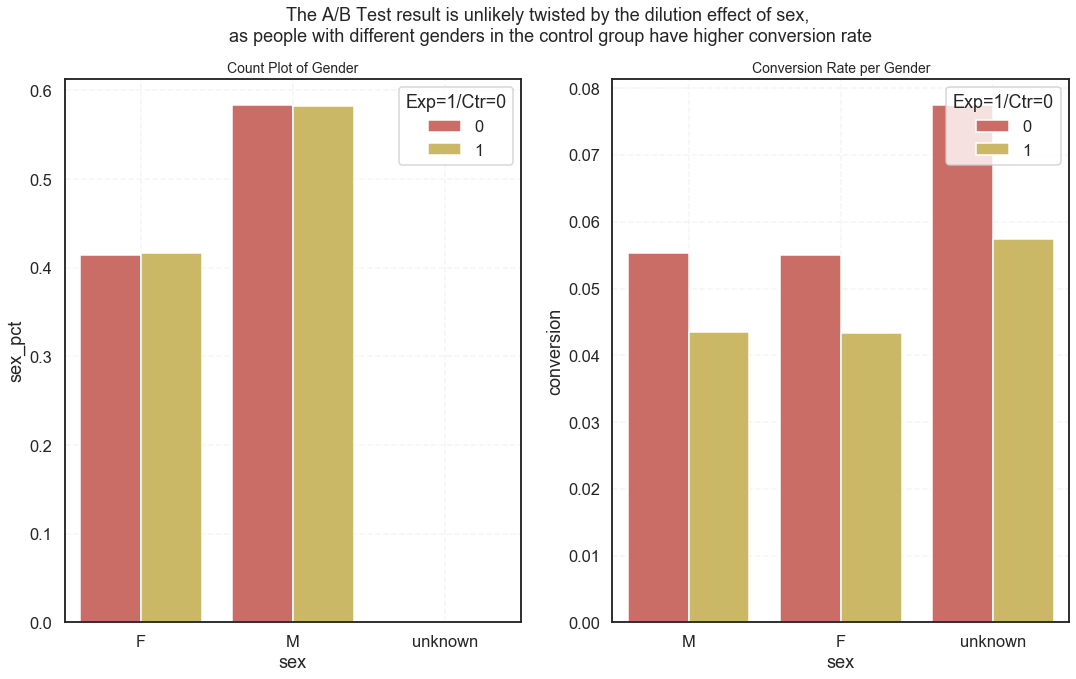

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))

traffic_by_sex = data.groupby(by= ["sex","test"])["user_id"].count().reset_index()
traffic_by_sex.columns = ["sex","test","cnt_sex"]
traffic_by_sex["sex_pct"] = 0
traffic_by_sex.loc[traffic_by_sex.test == 1,"sex_pct"] = traffic_by_sex[traffic_by_sex.test == 1]["cnt_sex"]/SIZE_EXP
traffic_by_sex.loc[traffic_by_sex.test == 0,"sex_pct"] = traffic_by_sex[traffic_by_sex.test == 0]["cnt_sex"]/SIZE_CTR

sns.barplot(x='sex',y = "sex_pct",hue = "test", data=traffic_by_sex, ax=axes[0], palette=sns.color_palette("hls", 8))
axes[0].set_title('Count Plot of Gender', fontsize=14)
axes[0].grid(linestyle="--", alpha=0.2)
axes[0].legend(title = "Exp=1/Ctr=0",loc = 1)

sns.barplot(x='sex', y='conversion',hue = "test", data=data, ci=0, ax=axes[1], palette=sns.color_palette("hls", 8))
axes[1].set_title('Conversion Rate per Gender', fontsize=14)
axes[1].grid(linestyle="--", alpha=0.2)
axes[1].legend(title = "Exp=1/Ctr=0",loc = 1)


#fig.legend(["Control group","Experiment group"],loc = 0)
fig.suptitle("The A/B Test result is unlikely twisted by the dilution effect of sex, \nas people with different genders in the control group have higher conversion rate",fontsize = 18)
plt.show()

# 6. Validation Algorithm Design

In [102]:
def spanish_localized_feature_test_check(test_table, user_table):
    '''
    This validation function takes in two pandas dataframe object 
    with all the test information and user characteristics information,
    and returns False if the result cannot be trusted (i.e. population incorrectly specified)
    and True otherwise
    
    Input:
        test_table (pandas dataframe)
        user_table (pandas dataframe)
    '''
    
    data = pd.merge(left=test, right=user, how='left', on='user_id')
    data["country"] = data.country.fillna("unknown")
    
    if "Spain" in list(data[data.test == 0].country):
        return False
    else:
        return True

In [103]:
spanish_localized_feature_test_check(test, user)

False